第一次实战无从下手，找了[这篇笔记](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook)学习一下。这是一道房价预测的题目

# 1.So... What can we expect?
为了理解数据，我们可以创建一个`Excel`包含以下的列

+ 变量-变量名称
+ `type`-变量类型的标识。此字段有两个可能的值：“数值”或“分类”。“数值”是指其值为数字的变量，“分类”是指值为类别的变量
+ `segment`-变量段的标识。我们可以定义三个可能的部分：`building`、`space`或`location`。当我们说`building`时，我们指的是与建筑物的物理特性相关的变量（例如`OverallQual`）。当我们说`space`时，我们指的是报告房屋空间属性的变量（例如`TotalBsmtSF`）。最后，当我们说`location`时，我们指的是一个变量，它提供了房子所在位置的信息（例如`Neighborhood`）。
+ 预期-我们对“销售价格”变量影响的预期。我们可以使用“高”、“中”和“低”作为可能值的分类量表。
+ 结论-在快速查看数据后，我们得出了关于变量**重要性**的结论。我们可以使用与“预期”中相同的分类量表。
+ 评论-我们的任何一般性评论。

> 相当于分析了对每个特征进行了预分析：
>
> 1.它的值是否是数字
>
> 2.它在描述建筑的空间、位置还是相关的物理特性
>
> 3.它对房价的影响大吗
>
> 4.经过验证后（一般是看散点图）它对房价的影响还大吗
>
> 5.可以随意写一些评论

> 解释几个词
>
> **OverallQual** :Overall Quality 房屋总体质量
>
> **TotalBsmtSF**: Total Basement Square Feet 地下室总面积
>
> **Neighborhood**:可能指房屋所在的社区或街区——不同社区的房价有明显差异

虽然`type`和`segment`字段可能在将来被参考，但预期更重要，因为它将帮助我们培养“第六感”。为了填写这一栏，我们应该一个个阅读所有变量的description并且问自己：我在买房时会考虑这个变量吗？如果是这样，这个变量有多重要？这些信息是否已经在其他变量中出现过？（例如`LandContour`给出了房子的平坦度，那还需要`LandSlope`吗？）

经过这项艰巨的练习，我们可以过滤电子表格（训练集数据），仔细查看“高”“预期”的变量。然后，我们可以快速绘制这些变量与“销售价格”之间的散点图，填写“结论”栏，这是我们对“预期”的修正。

> 也就是说训练集给出的数据有很多特征（变量），一个个考虑它们对“销售价格”的影响程度，标记为“高”，“中”或者“低”，并画出各个被标记为高的变量与销售价格的散点图。通过散点图可以比较容易地看出该特征（变量）对销售价格的影响。

~~我~~作者经历了这个过程，筛选出了几个有高预期（对房价影响大）的特征

+ OverallQual.对房屋的整体材料和装修进行评分
+ YearBuilt.建造日期
+ TotalBsmtSF.地下室总面积
+ GrLivArea.地上生活区面积

最终得到了两个`building`变量（`OverallQual`和`YearBuilt`），两个`space`变量（`TotalBsmtSF`和`GrLivArea`）。出乎意料的是，`Neigborhood`变量在数据检查后被排除了，这违背了房地产界的口头禅，即重要的是“位置，位置和位置”。这可能和使用散点图而不是箱线图有关。我们可视化数据的方式往往会影响我们的结论。

OK，这项工作的重点是稍微考虑一下我们的数据和预期，现在是时候进行下一步工作了。

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#下面这坨注释的代码是打开kaggle笔记自带的，运行会输出数据文件的存放路径
"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""

df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_train.columns #这个可以查看数据集都有哪些列（特征）

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# 2.First things first: analysing 'SalePrice'
还可以查看数据集各列的`describe`以及图像

In [5]:
#descriptive statistics summary
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

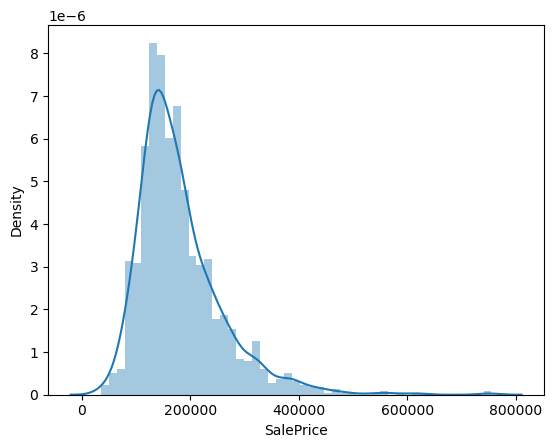

In [6]:
#histogram
sns.distplot(df_train['SalePrice']);

In [7]:
#偏度和峰度
print("偏度: %f" % df_train['SalePrice'].skew())
print("峰度: %f" % df_train['SalePrice'].kurt())

偏度: 1.882876
峰度: 6.536282


偏度：
偏度衡量数据分布的对称性，反映分布的不对称程度。
计算公式：
$\text{Skewness} = \frac{E[(X - \mu)^3]}{\sigma^3}$  
偏度为0:分布对称；偏度大于0:右偏，长尾在右侧；偏度小于0:左偏，长尾在左侧。


峰度：
峰度衡量数据分布的峰态，反映尾部厚度。
计算公式：
$ \text{Skewness} = \frac{E[(X - \mu)^3]}{\sigma^3} $  
峰度为3:与正态分布相同；峰度大于3:尖峰厚尾；峰度小于3:低峰薄尾；

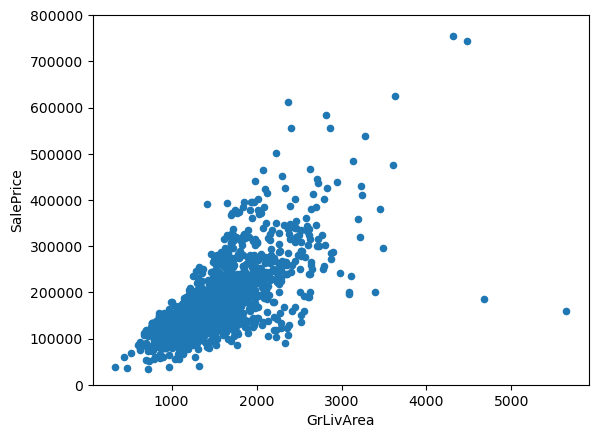

In [9]:
#绘制面积-销售价格的散点图
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)#把两个若干行，1列的向量拼接成了 一个若干行，2列的向量
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));#根据下图看来，参数ylim是纵坐标值域

上面这几行，读取的csv文件可以直接画图和进行一些计算，可以注意一下。

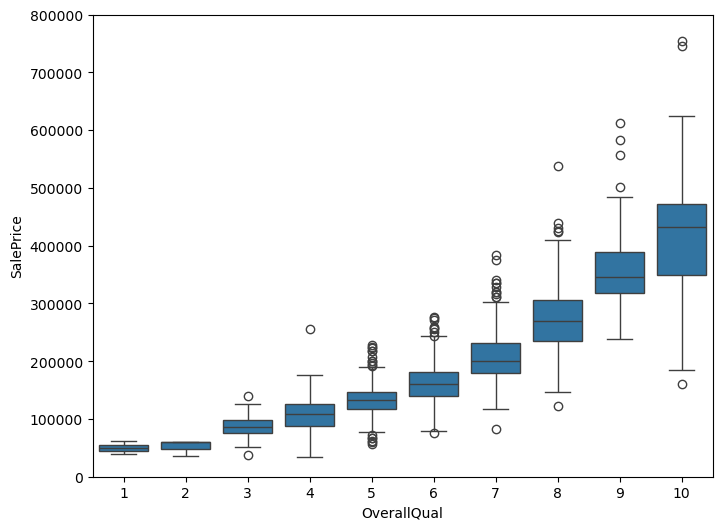

In [11]:
#整体评价与售价的关系(这个好像叫箱线图  我不知道箱线图)
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

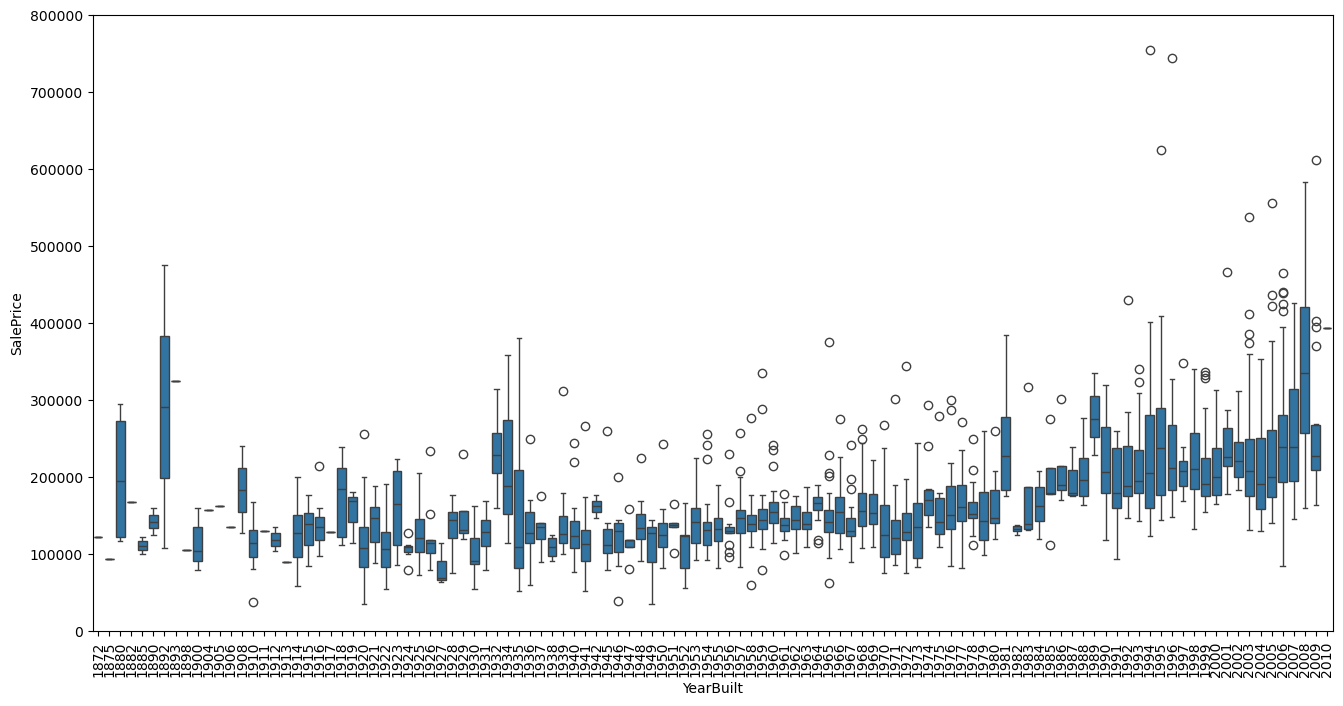

In [12]:
#建造年份与售价的关系
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

**总结**
+ “地上生活区面积”和“地下室面积”和“售价”的关系似乎是线性的。都是线性正相关。
+ “总体评价”和“建造年份”似乎也与“售价”有关，“总体评价”的关系似乎更强
我们只分析了四个变量，有更多其它的变量需要我们分析。这里的技巧是选择正确的特征并且不要在他们之间定义太复杂的关系。
# 3.keep calm and work smart

到目前为止我们只是遵循直觉分析了我们认为重要的变量，尽管我们努力使我们的分析具有客观性，但不得不说这样的做法是主观的  
让我们试着做一个更客观的分析  
用到了三个图（暂时不太懂是什么东西）
+ 相关矩阵
+ “出售价格”相关矩阵
+ 相关性最强的变量之间的散点图

**相关矩阵**

In [54]:
# #correlation matrix
# corrmat = df_train.corr() #计算各数值变量之间的相关性，暂时报错
# f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True);

<class 'pandas.core.frame.DataFrame'>
<class 'method'>


<bound method DataFrame.corr of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Ut